# Part 1: Getting started

# Jet Tagging Hands-on Lab with QKeras + HLS4ML

# ✅ Part 1: Getting Started

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)

2025-04-04 19:29:23.045218: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 19:29:23.062592: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 19:29:23.152090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 19:29:23.153019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-04 19:29:23.900841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

## Fetch the jet tagging dataset from Open ML

In [ ]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [ ]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [ ]:
le.classes_

array(['g', 'q', 't', 'w', 'z'], dtype=object)

In [ ]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [ ]:
# np.save('X_train_val.npy', X_train_val)
# np.save('X_test.npy', X_test)
# np.save('y_train_val.npy', y_train_val)
# np.save('y_test.npy', y_test)
# np.save('classes.npy', le.classes_)

## Construct a model
We'll' use QKeras to build a quantized model.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [ ]:
# keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation

# qkeras imports
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.autoqkeras.utils import print_qmodel_summary

In [ ]:
model = Sequential()
model.add(
    QDense(
        64,
        input_shape=(16,),
        name='fc1',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(
    QDense(
        32,
        name='fc2',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(
    QDense(
        32,
        name='fc3',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(
    QDense(
        5,
        name='output',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation='softmax', name='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 64)                1088      
                                                                 
 relu1 (QActivation)         (None, 64)                0         
                                                                 
 fc2 (QDense)                (None, 32)                2080      
                                                                 
 relu2 (QActivation)         (None, 32)                0         
                                                                 
 fc3 (QDense)                (None, 32)                1056      
                                                                 
 relu3 (QActivation)         (None, 32)                0         
                                                                 
 output (QDense)             (None, 5)                

In [ ]:
print_qmodel_summary(model)

fc1                  u=64 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
relu1                quantized_relu(6,0)
fc2                  u=32 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
relu2                quantized_relu(6,0)
fc3                  u=32 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
relu3                quantized_relu(6,0)
output               u=5 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 



## Train the model
We'll use Adam optimizer with categorical crossentropy loss.

The callbacks will decay the learning rate and save the model as "best_model.h5"

The model isn't very complex, so this should just take a few minutes even on the CPU.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=['categorical_crossentropy'], metrics=['accuracy'])

model.fit(
    X_train_val,
    y_train_val,
    batch_size=1024,
    epochs=10,
    validation_split=0.25,
    shuffle=True
)

Epoch 1/10
487/487 [==============================] - 3s 5ms/step - loss: 0.9659 - accuracy: 0.6873 - val_loss: 0.8138 - val_accuracy: 0.7354
Epoch 2/10
487/487 [==============================] - 2s 4ms/step - loss: 0.7801 - accuracy: 0.7446 - val_loss: 0.7673 - val_accuracy: 0.7484
Epoch 3/10
487/487 [==============================] - 2s 4ms/step - loss: 0.7541 - accuracy: 0.7517 - val_loss: 0.7526 - val_accuracy: 0.7521
Epoch 4/10
487/487 [==============================] - 2s 4ms/step - loss: 0.7412 - accuracy: 0.7547 - val_loss: 0.7417 - val_accuracy: 0.7547
Epoch 5/10
487/487 [==============================] - 2s 4ms/step - loss: 0.7322 - accuracy: 0.7569 - val_loss: 0.7336 - val_accuracy: 0.7564
Epoch 6/10
487/487 [==============================] - 2s 4ms/step - loss: 0.7254 - accuracy: 0.7586 - val_loss: 0.7303 - val_accuracy: 0.7570
Epoch 7/10
487/487 [==============================] - 2s 5ms/step - loss: 0.7211 - accuracy: 0.7597 - val_loss: 0.7241 - val_accuracy: 0.7590
Epoch 

## Check performance
Check the accuracy and make a ROC curve

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc, roc_curve


# confusion matrix code from Maurizio
# /eos/user/m/mpierini/DeepLearning/ML4FPGA/jupyter/HbbTagger_Conv1D.ipynb
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    cbar = plt.colorbar()
    plt.clim(0, 1)
    cbar.set_label(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plotRoc(fpr, tpr, auc, labels, linestyle, legend=True):
    for _i, label in enumerate(labels):
        plt.plot(
            tpr[label],
            fpr[label],
            label='{} tagger, AUC = {:.1f}%'.format(label.replace('j_', ''), auc[label] * 100.0),
            linestyle=linestyle,
        )
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.ylim(0.001, 1)
    plt.grid(True)
    if legend:
        plt.legend(loc='upper left')
    plt.figtext(0.25, 0.90, 'hls4ml', fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)


def rocData(y, predict_test, labels):
    df = pd.DataFrame()

    fpr = {}
    tpr = {}
    auc1 = {}

    for i, label in enumerate(labels):
        df[label] = y[:, i]
        df[label + '_pred'] = predict_test[:, i]

        fpr[label], tpr[label], threshold = roc_curve(df[label], df[label + '_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
    return fpr, tpr, auc1


def makeRoc(y, predict_test, labels, linestyle='-', legend=True):
    if 'j_index' in labels:
        labels.remove('j_index')

    fpr, tpr, auc1 = rocData(y, predict_test, labels)
    plotRoc(fpr, tpr, auc1, labels, linestyle, legend=legend)
    return predict_test


def print_dict(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent + 1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

5188/5188 [==============================] - 3s 576us/step
Accuracy: 0.7586686746987952


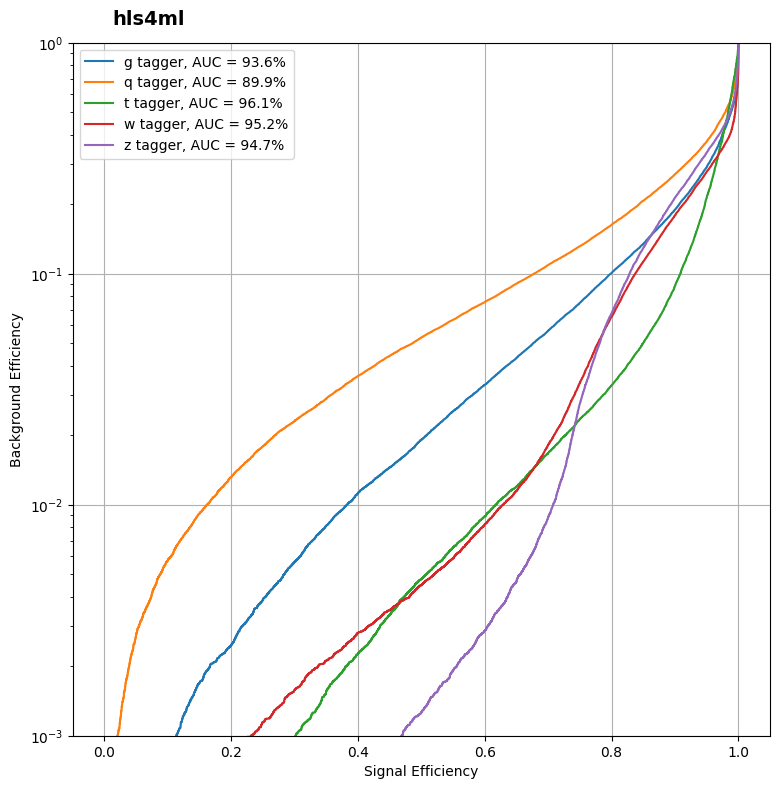

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = makeRoc(y_test, y_keras, le.classes_)

## Convert the model to FPGA firmware with hls4ml
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
Then we will synthesize the model with Vitis HLS and check the metrics of latency and FPGA resource usage.

### Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [ ]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis')
print("-----------------------------------")
print("Configuration")
print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', io_type = "io_parallel", output_dir='model_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

In [ ]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [ ]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


## Compare
That was easy! Now let's see how the performance compares to Keras:

Keras  Accuracy: 0.7586686746987952
hls4ml Accuracy: 0.6900722891566266


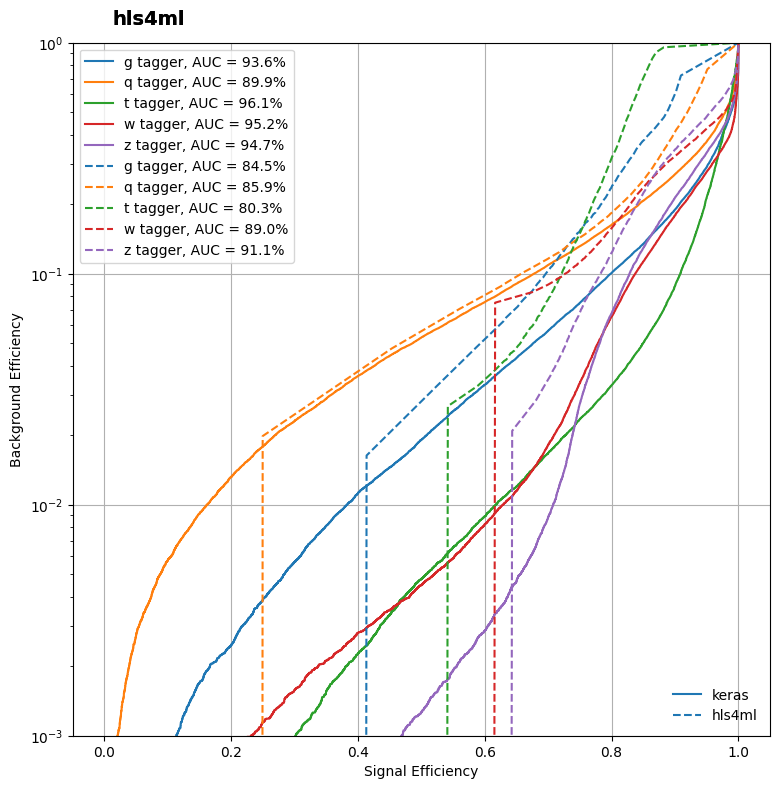

In [ ]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now we'll actually use Vitis HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vitis HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vitis_hls.log`

In [ ]:
hls_model.build(csim=False)

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)